In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import random

# Load Data

In [2]:
# TODO: Load data here.
indexes = pd.read_csv('hw3_Data1/index.txt', delimiter = '\t', header = None)
x = pd.read_csv('hw3_Data1/gene.txt', delimiter = ' ', header = None).to_numpy().T
y = pd.read_csv('hw3_Data1/label.txt', header = None).to_numpy()
y = (y>0).astype(int).reshape(y.shape[0])

In [3]:
print(indexes)

              0       1       2   3         4  \
0      Hsa.3004  H55933  3' UTR   1  203417.0   
1     Hsa.13491  R39465  3' UTR  2a   23933.0   
2     Hsa.13491  R39465  3' UTR  2a   23933.0   
3     Hsa.37254  R85482  3' UTR  2a  180093.0   
4       Hsa.541  U14973    gene   1       NaN   
...         ...     ...     ...  ..       ...   
1995    Hsa.984  M33210    gene   1       NaN   
1996  Hsa.35124  H18490  3' UTR  2a  171840.0   
1997   Hsa.3952  H40891  3' UTR  2a  175983.0   
1998  Hsa.32734  R77780  3' UTR  2a  145300.0   
1999   Hsa.9683  T49647  3' UTR  2a   67762.0   

                                                      5  
0     H.sapiens mRNA for homologue to yeast ribosoma...  
1     EUKARYOTIC INITIATION FACTOR 4A (Oryctolagus c...  
2     EUKARYOTIC INITIATION FACTOR 4A (Oryctolagus c...  
3     SERUM RESPONSE FACTOR (Homo sapiens)          ...  
4     Human ribosomal protein S29 mRNA, complete cds...  
...                                                 ...  
1995 

In [4]:
print(indexes.iloc[4])

0                                              Hsa.541
1                                               U14973
2                                                 gene
3                                                    1
4                                                  NaN
5    Human ribosomal protein S29 mRNA, complete cds...
Name: 4, dtype: object


In [5]:
print(x.shape)

(62, 2000)


In [6]:
print(x)

[[8.5894163e+03 5.4682409e+03 4.2634075e+03 ... 7.5677500e+01
  8.3522500e+01 2.8701250e+01]
 [9.1642537e+03 6.7195295e+03 4.8834487e+03 ... 1.8656750e+02
  4.4472500e+01 1.6773750e+01]
 [3.8257050e+03 6.9703614e+03 5.3699688e+03 ... 4.2656250e+01
  1.6092500e+01 1.5156250e+01]
 ...
 [6.7306250e+03 3.4721250e+03 2.5594625e+03 ... 1.3352125e+02
  9.3098750e+01 7.4325000e+00]
 [6.2346225e+03 4.0053000e+03 3.0936750e+03 ... 1.1820125e+02
  3.2687500e+01 2.3265000e+01]
 [7.4720100e+03 3.6539341e+03 2.7282162e+03 ... 7.7215000e+01
  4.9862500e+01 3.9631250e+01]]


In [7]:
print(y.shape)

(62,)


In [8]:
print(y)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1]


# Feature ranking : One-by-one Feature Selection

# Use Similarity-Based: Fisher Score (without normalization)

In [9]:
def get_ui(x,i): #data x and index i, ui is the mean of feature i
    target = x[:,i]
    return np.mean(target)

In [10]:
def get_uij_and_varij(x,i,j):
    target = []
    for k in range(62):
        if y[k] == j:
            target.append(x[k,i])
            
    uij = np.mean(target)
    varij = np.var(target)
    return uij,varij

In [11]:
def insert(idx,idx_score,i,i_score):
    output_idx = idx
    output_idx_score = idx_score
    for k in range(len(output_idx)):
        if i_score >= output_idx_score[k]:
            output_idx.insert(k,i)
            output_idx_score.insert(k,i_score)
            break
    return output_idx,output_idx_score

In [12]:
# TODO: Design your score function for feature selection
# ranking_idx = np.linspace(0,1999,2000,dtype=int)
# random.shuffle(ranking_idx)
ranking_idx = [-1]
ranking_idx_score = [-1]
nij = [62-np.count_nonzero(y),np.count_nonzero(y)]
for i in range(2000): #pick ith feature
#     print(i)
    up = 0
    down = 0
    for j in range(2): #class j
        nj = nij[j] 
        uij,varij = get_uij_and_varij(x,i,j)
        ui = get_ui(x,i)
        up += nj*((uij-ui)**2)
        down += nj*varij
    fisher_score = up/down
    ranking_idx,ranking_idx_score = insert(ranking_idx,ranking_idx_score,i,fisher_score)
# TODO: To use the provided evaluation sample code, you need to generate ranking_idx, which is the sorted index of feature

# Feature evaluation

In [20]:
# Use a simple dicision tree with 5-fold validation to evaluate the feature selection result.
# You can try other classifier and hyperparameter.
score_history = []
for m in range(1, 2001, 1): # m = 5,10,15,...,2000 -> m = 1,2,3,...,2000
    # Select Top m feature
    x_subset = x[:, ranking_idx[:m]]

    # Build random forest
#     clf = DecisionTreeClassifier(random_state=0)
    clf = SVC(kernel='rbf', random_state=0) #build SVM

    # Calculate validation score
    scores = cross_val_score(clf, x_subset, y, cv=5)

    # Save the score calculated with m feature
    score_history.append(scores.mean())

# Report best accuracy.
print(f"Max of Decision Tree: {max(score_history)}")
# print(f"Number of features: {np.argmax(score_history)*5+5}")
print(f"Number of features: {np.argmax(score_history)}")

Max of Decision Tree: 0.8692307692307694
Number of features: 72


# Visualization

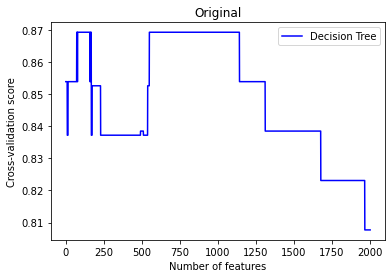

In [21]:
plt.plot(range(1, 2001, 1), score_history, c='blue')
plt.title('Original')
plt.xlabel('Number of features')
plt.ylabel('Cross-validation score')
plt.legend(['Decision Tree'])
plt.savefig('1-3_result.png')

# Record (Max of Decision Tree / Number of features)

completely_random : 0.8538461538461538 / 460

fisher_score = 0.8705128205128204 / 35

fisher_score(skip=1) = 0.9038461538461539 / 67

In [ ]:
np.var(x[:,1])

In [ ]:
np.count_nonzero(y)

In [ ]:
# print(ranking_idx)

In [ ]:
print(ranking_idx_score)

# Validate mutiple feature 

pick index = 248 , 764 , 492 features

In [ ]:
import numpy as np
z1 = np.reshape(x[:,248].T,(1,62))
z2 = np.reshape(x[:,764].T,(1,62))
z3 = np.reshape(x[:,492].T,(1,62))
Z = np.concatenate((z1,z2,z3))
print(z1.shape)
print(Z.shape)

In [ ]:
np.reshape(Z[:,61],(3,1))

# get SB

In [ ]:
def cal_uk(Z,k):
    for i in range(62):
        if int(y[i]) == k:
#             print('dfb')
            try:
                target = np.concatenate((target,np.reshape(Z[:,i],(3,1))),axis=1)
            except:
                target = np.reshape(Z[:,i],(3,1))
#     print(target.shape)
#     print(np.average(target,axis=1).shape)
    
    return np.average(target,axis=1)

In [ ]:
u0 = np.reshape(cal_uk(Z,0),(3,1))
u1 = np.reshape(cal_uk(Z,1),(3,1))
u = nij[0]*u0 + nij[1]*u1
SB = np.zeros((3,3))
for k in range(2):
    nk = nij[k]
    if k==0:
        uk=u0
    else:
        uk=u1
    SB += nk* np.matmul((uk-u),(uk-u).T)
# print(SB)

# get St

In [ ]:
St = np.zeros((3,3))
for i in range(62):
    zi = np.reshape(Z[:,i],(3,1))
    St += np.matmul((zi-u),(zi-u).T)

# get fisher score

In [ ]:
score = 0
A = np.matmul(SB,np.linalg.inv(St+1e-2*np.identity(3)))
for i in range(3):
    score += A[i,i]

In [ ]:
print(score)

In [ ]:
sum([0.6635444906271158,0.5524959834149036, 0.5335986349543933])

# 結論: 故不是score直接相加

In [ ]:
a = [2 ,3]
a[:0]

In [ ]:
for m in range(1, 2001, 1):
    print(m)

In [ ]:
for m in range(5, 2001, 5):
    print(m)

In [ ]:
np.argmax(score_history)

In [ ]:
# print(score_history)
print(score_history[67])